# Example notebook: how to fit experimental data to the Michaelis-Menten equation

In biochemistry, the Michaelis–Menten equation is one of the best-known models of enzyme kinetics. The model takes the form of an equation describing the rate of enzymatic reactions, by relating reaction rate $v$ to $[S]$, the concentration of a substrate $S$. The velocity $v$ is parameterized by—also related to—the turnover number $k_{cat}$ and the Michaelis constant $K_M$. The most useful form of the equation for the biochemist relates the quotient of velocity $v$ and enzyme concentration $[E]$ to the substrate concentration $[S]$, the catalytic rate $k_{cat}$, and the Michaelis constant $K_M$ by 

$$\frac{v}{[E]}=\frac{k_{cat}*[S]}{K_M + [S]}$$

This notebook is a tutorial for the experimental biochemist who has collected data on the rate of product formation under different concentrations of substrate, as we frequently do in the [Siegel group](https://sites.google.com/site/ucdsiegellab/). Let's begin with data workup. 

## Data workup from a UV/vis plate assay

Our UV/vis plate assay follows the accumulation of 4-nitrophenol (pNP), and provides rates in units of OD/min. We need to convert these into M/min since what we actually care about is product concentration (not OD). A standard curve relating OD/min to concentration of product in M/min can be used to transform the OD/min data.

* Convert your rates from OD/min into M/min (molar per minute) using a standard curve. 

> In this example, we have experimentally determined that $$ \textrm{ pNP } \frac{M}{min} = 0.0002 \textrm{ pNP } \frac{OD}{min} $$.

* Convert your enzyme concentration from mg/mL into M by dividing by the extinction coefficient of the protein and correcting for any dilution in your assay procedure 

> In this case, the extinction coefficient of BglB is 113330, and we diluted the enzyme twice: first 100-fold and then in the assay plate 4-fold. 

* Finally, divide the rates you observe (in units of M/min) by the enzyme concentration that you are testing (in units of M), to obtain rates in min$^{-1}$
* Convert your substrate concentrations into M as well
* Put them in a CSV table like the one in this repository called `example_data.csv` 

> In this case, these unit conversions have already been performed on the example data. We could use the following Python code to do the unit conversions for us. 

In [29]:
ext_coef = 113330
protein_yield = 1 #units of mg/mL
protein_conc = protein_yield / ext_coef / 100 / 4
df.rate = 0.0002 * df.rate / protein_conc

## Make a plot of your data

Let's generate a plot of our data using the Python package `matplotlib` to see if it will fit the Michaelis-Menten equation.

First, let's import the packages we'll need and do some iPython magic to get the plots to display on this page.

In [30]:
import pandas
%matplotlib inline 

Next, we'll read in the example data into a [Pandas](http://pandas.pydata.org) `DataFrame`, a data structure similar to a table that's a whole lot smarter and more useful. You can call the `DataFrame` whatever you like. I'll call this one `df`. 

In [31]:
df = pandas.read_csv( 'example_data.csv' )

Now that we have our data in a `DataFrame`, we can use the built-in method `plot()` of the `DataFrame` to make a quick scatter plot of our data and display it on screen.

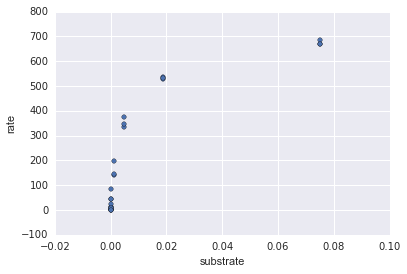

In [32]:
df.plot( x='substrate', y='rate', kind='scatter' )

That looks like it will fit the Michaelis-Menten equation. Since we've converted all our values to use the same units, we can estimate $k_{cat}$ and $K_M$ from looking at the plot. 

I estimate $k_{cat}$ to be about 700 min$^{-1}$ and $K_M$, the substrate concentration where the rate it half its max, to be 0.005 M, or 5 mM. 

## Fit your data to the Michaelis-Menten equation to determine $k_{cat}$ and $K_M$

Next, we'll use the Python module [SciPy](http://www.scipy.org) to perform a nonlinear least-squares optimization to determine the values of $k_{cat}$ and $K_M$ that fit our data best. First, we'll import SciPy and a couple of Numpy modules that we'll need later 

In [33]:
from scipy.optimize import curve_fit 
from numpy import diag, sqrt

and define the Michaelis-Menten equation in Python code 

In [34]:
def v( s, kcat, km ):
    return ( kcat * s ) / ( km + s )

We need to provide `curve_fit` with initial guesses at the parameters, which we estimated from the scatter plot above. The value for $k_{cat}$ (the maximum rate observed) appears to be about 700 min$^{-1}$, and the value for $K_M$ looks to be about 0.005. 

Put these in to a new tuple, called `p0`. 

In [35]:
p0 = ( 650, 0.005 )

Now we're ready to use `curve_fit`. [The `curve_fit` documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) indicates that the function returns two arrays, called `popt` (= parameter optimums) and `pcov` (= parameter covariance). From the documentation:

> **popt** : array
> Optimal values for the parameters so that the sum of the squared error of f(xdata, *popt) - ydata is minimized

> **pcov** : 2d array
> The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

I recommend setting up your code to have the function return into two variables called `popt` and `pcov`.

In this next step, we'll perform the optimization and convert our one standard deviation errors into percent, which I find easier to make sense of for large data sets. 

In [36]:
popt, pcov = curve_fit( v, df.substrate, df.rate, p0=p0 )
perr = sqrt( diag( pcov ) )

# calculate percent errors
for i in range( len( popt ) ):
    if not popt[ i ] or perr[ i ] > popt[ i ]:
        popt[ i ] = perr[ i ] = None 
    else:
        perr[ i ] = perr[ i ] / popt [ i ] * 100

Whew! That's it! Let's print out our results in a nice format, rounding numbers as necessary

In [37]:
results = { 
    'kcat': '{:0.1f}'.format( popt[0] ), 
    'kcat_std_err': '{:0.1f}%'.format( perr[0] ),
    'km': '{:0.4f}'.format( popt[1] ), 
    'km_std_err': '{:0.1f}%'.format( perr[1] ) 
}

print pandas.Series( results )

kcat             693.4
kcat_std_err      1.8%
km              0.0045
km_std_err        7.2%
dtype: object


OK, that is a nice simple example, but what if you have collected data on more than one sample and want to fit them all? 

## How to fit multiple samples

If you have multiple samples you'd like to fit at once, we can write a slightly more sophisticated program by wrapping up our previous code in a function and then using the `pandas.DataFrame.groupby()` method to apply it to all of our samples.

To write this function, all we need to consider is a Pandas `DataFrame` object, `df`, exactly as we already have. 

In [38]:
def try_michaelis_menten_fit( df ):
    popt, pcov = curve_fit( v, df.substrate, df.rate, p0=p0 )
    perr = sqrt( diag( pcov ) )

    # percent errors 
    for i in range( len( popt ) ):
        if not popt[ i ] or perr[ i ] > popt[ i ]:
            popt[ i ] = perr[ i ] = None 
        else:
            perr[ i ] = perr[ i ] / popt [ i ] * 100
    
    # format results 
    results = { 
        'kcat': '{:0.1f}'.format( popt[0] ), 
        'kcat_std_err': '{:0.1f}%'.format( perr[0] ),
        'km': '{:0.4f}'.format( popt[1] ), 
        'km_std_err': '{:0.1f}%'.format( perr[1] ) 
    }
    
    return pandas.Series( results ) 

All we've done here is take our previous code and wrap it in a function called `try_michaelis_menten_fit` that takes a DataFrame `df` and returns a Series.

Try running it on the example data and see that it returns the same values. 

In [40]:
example_df = pandas.read_csv( 'example_data.csv' )
try_michaelis_menten_fit( example_df )

kcat             693.4
kcat_std_err      1.8%
km              0.0045
km_std_err        7.2%
dtype: object

Wrapping the code in the function `try_michaelis_menten_fit()` allows us to reuse the code on new `DataFrame`s. It's not very useful until we have some more samples in our data set. Look for some experimental data containing multiple samples in `multiple_example_data.csv`. 

We're also going to need some help for looking at plots of a lot more (about 100-fold more) data. We'll recruit [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) for this.

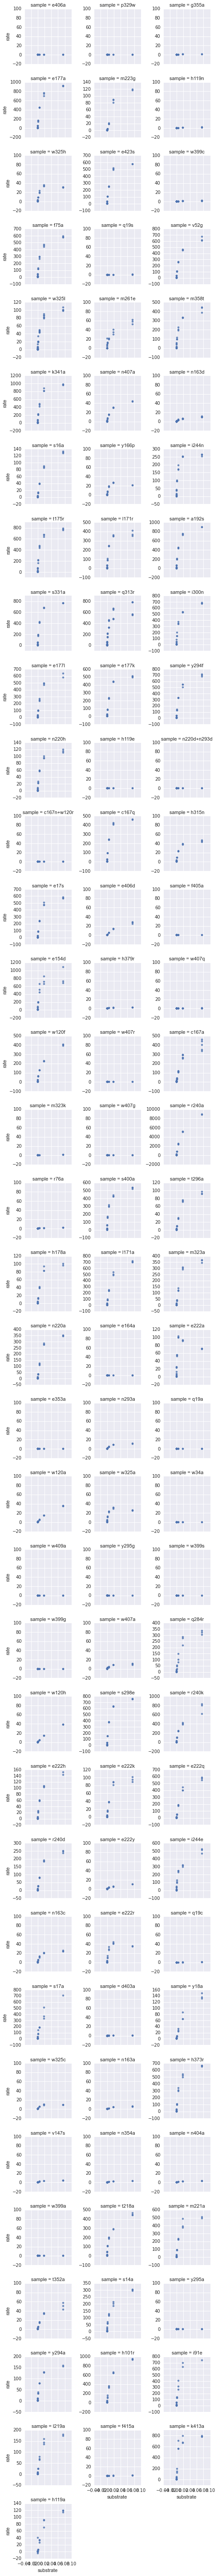

In [41]:
import seaborn 

multiple_example_df = pandas.read_csv( 'multiple_example_data.csv' )
seaborn.lmplot( fit_reg=False, col='sample', col_wrap=3, x='substrate', y='rate', data=multiple_example_df, sharey=False, size=2.3 )

Whew, that's a lot of data, representing a lot of work by a lot of people! A lot of these look like they will fit the Michaelis-Menten equation. Some of them don't. Our sanity-checking code will return "NaN" (Pandas jargon for "not a number") on those samples that don't fit the equation and those samples where the magnitude of the error is greater than the magnitude of the parameter. 

Let's try `apply`ing our `try_michaelis_menten_fit()` function to the `DataFrame` containing our data. 

In [42]:
multiple_example_df.groupby( 'sample' ).apply( try_michaelis_menten_fit )

,kcat,kcat_std_err,km,km_std_err
sample,,,,
a192s,945.8,1.0%,0.0051,3.6%
c167a,478.9,3.0%,0.0146,8.7%
c167n+w120r,0.4,21.9%,0.0262,56.0%
c167q,503.7,1.1%,0.0049,3.9%
d403a,1.2,22.7%,0.0440,49.1%
e154d,878.1,5.3%,0.0035,21.9%
e164a,0.2,3.6%,0.0010,16.9%
e177a,986.2,1.0%,0.0060,3.8%
e177k,554.9,1.3%,0.0062,4.8%


**Question**: Why is estimating the parameters faster than drawing the plots?